## Project Description


The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to underage people.

While conducting this evaluation, the following must be kept in mind:
*   The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.
*   Computer vision methods can be used to determine the age of a person from a photo.
*   The task then is to build and evaluate a model for verifying people's age.









## Initialization

In [19]:
# import the google drive library
from google.colab import drive

# mount the drive on collab to the path /content/drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [20]:
# import the necessary libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Load Data

The dataset is stored in the `/datasets/faces/` folder and contains the following:
- The `final_files` folder with 7.6k photos
- The `labels.csv` label file with two columns: `file_name` and `real_age`

There are a lot image files so it's best to avoid reading them all at once and to instead build a generator with the ImageDataGenerator generator.

In [21]:
# load the labels.csv file
labels = pd.read_csv('/content/drive/MyDrive/colab/faces/labels.csv')


## EDA

In [22]:
# preview the data in labels
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [23]:
# get info about the labels
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


There are 7,591 rows (labels) in our DataFrame. The data types are as expected.

In [24]:
# group real_age by the count of associated files and save it in the ages dataframe
ages = labels.groupby('real_age')['file_name'].count().reset_index()

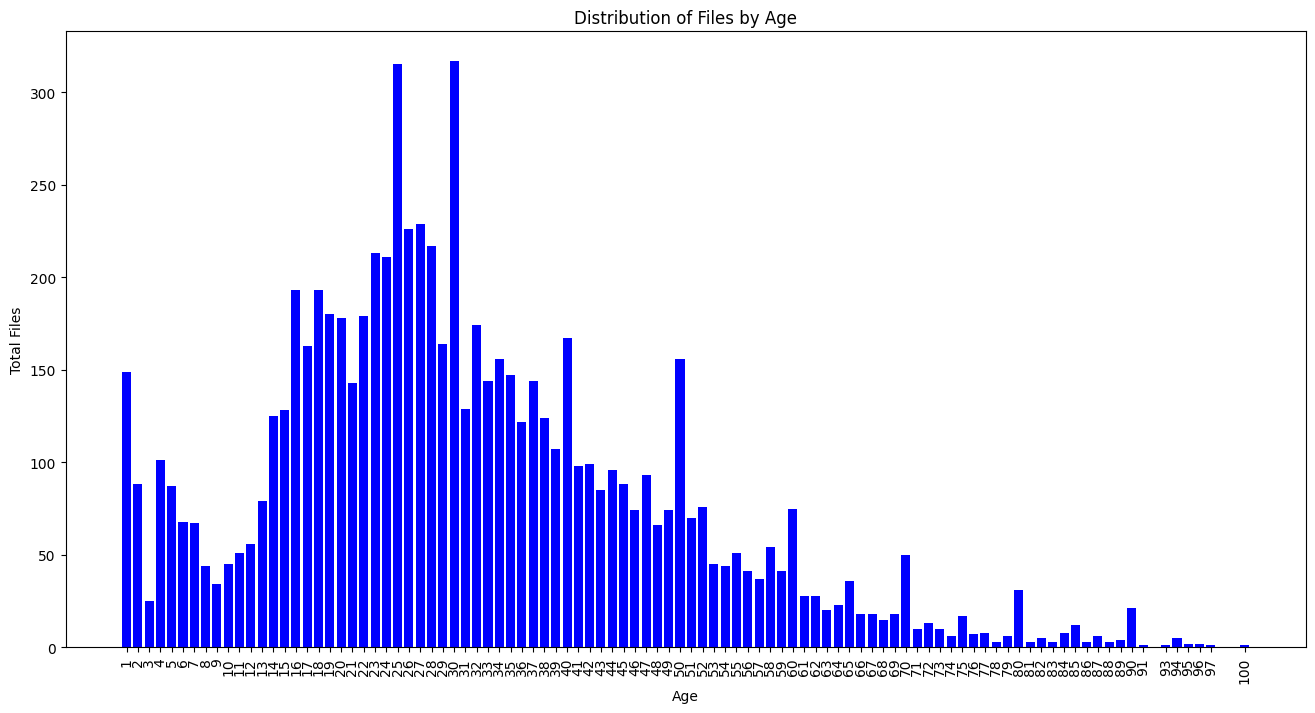

In [25]:
# set the figure size
plt.figure(figsize=(16, 8))

# plot a bar chart of real_age by the count of file names
plt.bar(ages['real_age'], ages['file_name'], color='blue')

# set the plot x-axis and y-axis labels
plt.xlabel('Age')
plt.ylabel('Total Files')

# set the plot title
plt.title('Distribution of Files by Age')

# set the x-ticks and rotate the labels by 90 degrees
plt.xticks(ages['real_age'], rotation=90)

# show the plot
plt.show()

The distribution of photos by age are skewed-left. The greatest concentration of photos are of people ranging from around 16 to 30 years old. This data will be helpful since it's important to train our model with photos of people who are relatively near in age to 21 year olds so we can address the task well.

We have less photos of adolescents and a generally downward trend in the number of photos for ages after 30.

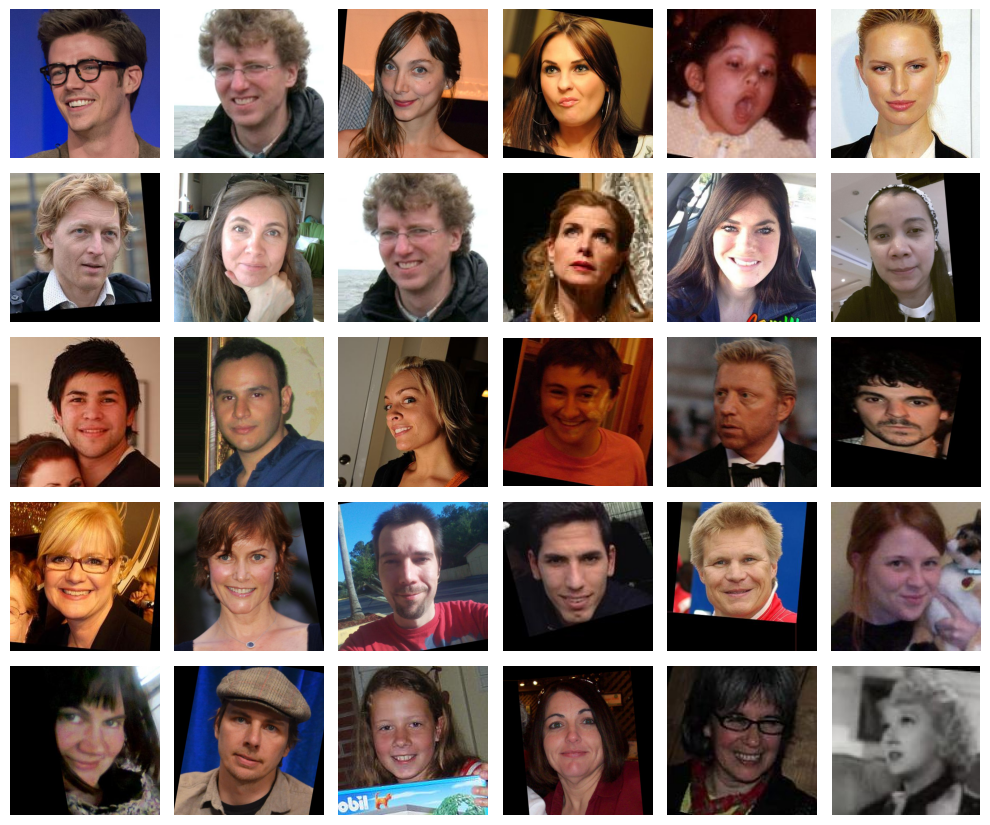

In [26]:
# import the necessary libraries to display a random set of the faces images
from PIL import Image
import os

# set the figure size
plt.figure(figsize=(10, 10))

# set the number of images to display
num_images = 30

# set the path to the images
path = '/content/drive/MyDrive/colab/faces/final_files/'

# get the list of files in the path
files = os.listdir(path)

# loop through the number of images to display
for i in range(num_images):
    # select a random file
    file = np.random.choice(files)

    # read the image using Pillow
    img = Image.open(os.path.join(path, file))

    # plot the image
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')

# use a tight layout
plt.tight_layout()

# display the plot
plt.show()

## Findings

From the random sample of 30 images displayed, we can observe many things.

The quality of the images vary significantly, and this variability can make the task of predicting age more difficult.

There is also a lot of variation in the image brightness, whether it's in color or is black and white, what the background behind the person is, and what facial expressions they are making, which can impact the model's ability to generalize. Some faces are not cenetered in the photo and are displayed at different angles which induces additional complexity into the model.

Since the age distribution is skewed toward younger people, the model will likely perform better on those age groups. Likely, certain genders and ethnicities are underrepresented in the data set, which may result in model bias (the model performs poorly for these underrepresented groups).





## Modeling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [27]:
# import the necessary libraries for modeling
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 #new


In [28]:
# define a function to load the train part of the dataset
def load_train(path):

    """
    It loads the train part of dataset from path
    """

    # load the labels file from the provided path
    labels = pd.read_csv(path + 'labels.csv')


    # create an instance of the ImageDataGenerator class with augmentations
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255,
                                        brightness_range=[0.6, 1.4],  # More aggressive brightness range
                                        horizontal_flip=True,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        rotation_range=30,  # Increased rotation range
                                        shear_range=0.2,  # Added shear transformation
                                        zoom_range=[0.7, 1.3]
                                       )


    # create a generator for the training data
    train_gen_flow = train_datagen.flow_from_dataframe(
       dataframe=labels,
       directory=path + 'final_files/',
       x_col='file_name',
       y_col='real_age',
       target_size=(224, 224), #chatgpt suggestion
       batch_size=32,
       class_mode='raw',
       subset='training',
       seed=12345)

    return train_gen_flow

In [29]:
# call the function to load the training data
train_gen_flow = load_train('/content/drive/MyDrive/colab/faces/')

Found 5694 validated image filenames.


In [30]:
# create a function to load the test data
def load_test(path='/content/drive/MyDrive/colab/faces/'):

    """
    It loads the validation/test part of dataset from path
    """

    # load the labels file from the provided path
    labels = pd.read_csv(path + 'labels.csv')

    # create an instance of ImageDataGenerator and set the validation split to 0.25
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    # create a generator for the validation dataset
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), #chatgpt suggestion
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [31]:
# apply the function to load the test dataset
test_gen_flow = load_test('/content/drive/MyDrive/colab/faces/')

Found 1897 validated image filenames.


In [32]:
# create a function to train the model
def create_model(input_shape):

    """
    It defines the model
    """

    # load the ResNet50 model with the top removed
    backbone = ResNet50(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False
            )

    ''' First ChatGPT Suggestion '''
    # freeze ResNet50 with the top removed
    # backbone.trainable = False

    # Partially unfreeze the layers to allow some fine-tuning
    for layer in backbone.layers[-20:]:  # Unfreezing the last 20 layers
        layer.trainable = True

    # create a Sequential model
    model = Sequential()

    # add the ResNet50 model to the Sequential model
    model.add(backbone)

    # add a GlobalAveragePooling2D layer
    model.add(GlobalAveragePooling2D())

    # Add more dense layers with L2 regularization and increased Dropout to improve generalization    model.add(Dense(1, activation='relu'))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Increased dropout rate
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    # final output layer for age prediction with ReLU to ensure positive values
    model.add(Dense(1, activation='relu'))

    # create an instance of the Adam optimizer with a learning rate of 0.0005
    optimizer = Adam(learning_rate=1e-5)

    # compile the model with the Adam optimizer, the mean squared error loss function, and the mean absolute error metric
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [33]:
# apply the function to create the model and save it in the model variable
model = create_model((224, 224, 3))

In [34]:
# create a function to train the model
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """

    # set the steps_per_epoch and validation_steps if not provided

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(train_data)


    # check if test_data yields data
    print("Checking test_data...")

    # create an iterator for the test_data generator
    try:
        next(test_data) # consume the first element
        print("test_data yielded data successfully.") # print a success message if the iterator yields data
    except StopIteration:
        print("test_data is empty or exhausted.") # print a failure measure if the iterator is empty or exhausted
        return model # return the model (or raise an exception)

    def get_callbacks():
      early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
      reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
      return [early_stopping, reduce_lr]

    # train the model
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=get_callbacks(),
              verbose=2)

    return model

In [36]:
# apply the function to train the model
train_model(model, train_gen_flow, test_gen_flow, epochs=30)

Checking test_data...
test_data yielded data successfully.
Epoch 1/30
178/178 - 129s - 727ms/step - loss: 117.7318 - mae: 7.8817 - val_loss: 99.4667 - val_mae: 7.1717 - learning_rate: 1.0000e-05
Epoch 2/30
178/178 - 11s - 62ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 99.4667 - val_mae: 7.1717 - learning_rate: 1.0000e-05
Epoch 3/30
178/178 - 131s - 735ms/step - loss: 118.8467 - mae: 7.9355 - val_loss: 101.9113 - val_mae: 7.2979 - learning_rate: 1.0000e-05
Epoch 4/30
178/178 - 11s - 61ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 101.9113 - val_mae: 7.2979 - learning_rate: 1.0000e-05
Epoch 5/30
178/178 - 129s - 726ms/step - loss: 109.7658 - mae: 7.5638 - val_loss: 95.9666 - val_mae: 6.8789 - learning_rate: 1.0000e-05
Epoch 6/30
178/178 - 21s - 116ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 95.9666 - val_mae: 6.8789 - learning_rate: 1.0000e-05
Epoch 7/30
178/178 - 181s - 1s/step - loss: 109.3502 - mae: 7.4966 - val_loss: 94.6712 - val_mae: 6.8174 - lea

<Sequential name=sequential_1, built=True>

## Conclusions

A mean absolute error of 6.5 means our predictions are off by 6.5 years on average. This isn't great because our task requires that we have high accuracy to determine an person's age for verification of their legal eligibility to purchase alcohol.

To improve our model, we should use a larger dataset with more diverse examples. Our model is limited in the distribution of ages present in the dataset, which makes it harder to learn the necessary patterns to predict age more accurately. Factors like a person's pose, facial expression, and any accessories they are wearing (hats, glasses, etc.) increases the model's complexity and reduces its ability to generalize well.

We should remove outliers or poor-quality images to reduce confusion within the model and balance the dataset across age groups to improve data quality.

However, as the model currently stands, it's not ready for our task. The risk of selling alcohol to minors is far too high.
